In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [23]:
data = pd.read_excel("Online Retail.xlsx")

In [24]:
data.shape

(541909, 8)

In [25]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [26]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [27]:
data = data.dropna(subset=["CustomerID"]) 

In [28]:
data = data[data["Quantity"] > 0]     

In [29]:
data["TotalPrice"] = data["Quantity"] * data["UnitPrice"]

In [30]:
latest_date = data["InvoiceDate"].max() + pd.Timedelta(days=1)

In [31]:
rfm = data.groupby("CustomerID").agg({
    "InvoiceNo": "count",
    "TotalPrice": "sum"
}).rename(columns={"InvoiceNo": "Frequency", "TotalPrice": "Monetary"})

In [32]:
recency = data.groupby("CustomerID")["InvoiceDate"].max().reset_index()
recency["Recency"] = (latest_date - recency["InvoiceDate"]).dt.days
recency = recency[["CustomerID", "Recency"]]

In [33]:
rfm = rfm.reset_index().merge(recency, on="CustomerID")

In [34]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

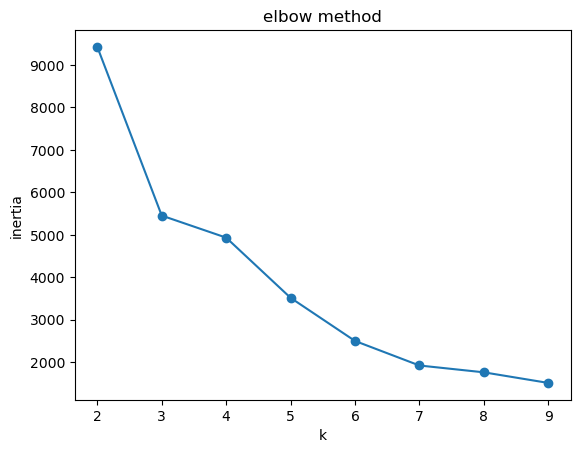

In [45]:
from warnings import filterwarnings
filterwarnings("ignore")
inertia = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2,10), inertia, marker='o')
plt.xlabel("k")
plt.ylabel("inertia")
plt.title("elbow method")
plt.show()

In [40]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

In [42]:
print("\nCluster averages:")
print(rfm.groupby("Cluster")[["Recency","Frequency","Monetary"]].mean())


Cluster averages:
            Recency    Frequency       Monetary
Cluster                                        
0         41.368762   103.066235    2028.208836
1        247.308333    27.789815     637.318510
2          4.692308  2566.000000  126118.310000


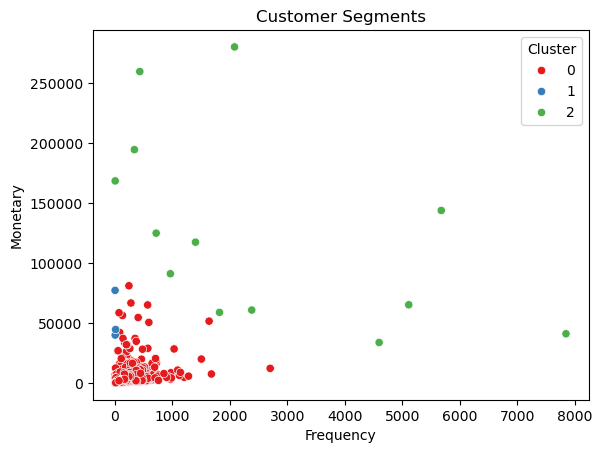

In [41]:
sns.scatterplot(x="Frequency", y="Monetary", hue="Cluster", data=rfm, palette="Set1")
plt.title("Customer Segments")
plt.show()

In [43]:
cluster_labels = {
    0: "Loyal",
    1: "Occasional",
    2: "Big Spenders"
}

rfm["ClusterLabel"] = rfm["Cluster"].map(cluster_labels)

In [44]:
rfm.to_csv("solution.csv", index=False)